## Floquet SPT-MBL Circuit Construction — One Floquet Cycle

This notebook cell constructs and visualizes a **single Floquet unitary step** for a 1D spin chain exhibiting **symmetry-protected topological (SPT)** order stabilized by **many-body localization (MBL)**.

### Model Overview:
- The Floquet unitary is composed of two non-commuting steps:
  1. **Local Z-field rotations**: simulate disordered transverse fields that introduce localization
  2. **Cluster-type XZX entanglers**: implement a three-body interaction that generates SPT order

Each cycle has the form:
\\[
U_F = \exp\left(-i J \sum_j X_{j-1} Z_j X_{j+1} \right) \cdot \exp\left(-i \sum_j h_j Z_j \right)
\\]

This structure preserves a \\(\mathbb{Z}_2 \times \mathbb{Z}_2\\) symmetry and is suitable for digital quantum simulation on NISQ devices.

We implement the circuit in Qiskit and draw it for a 6-qubit spin chain.


/opt/homebrew/Caskroom/miniconda/base/envs/qiskit-stable-env/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


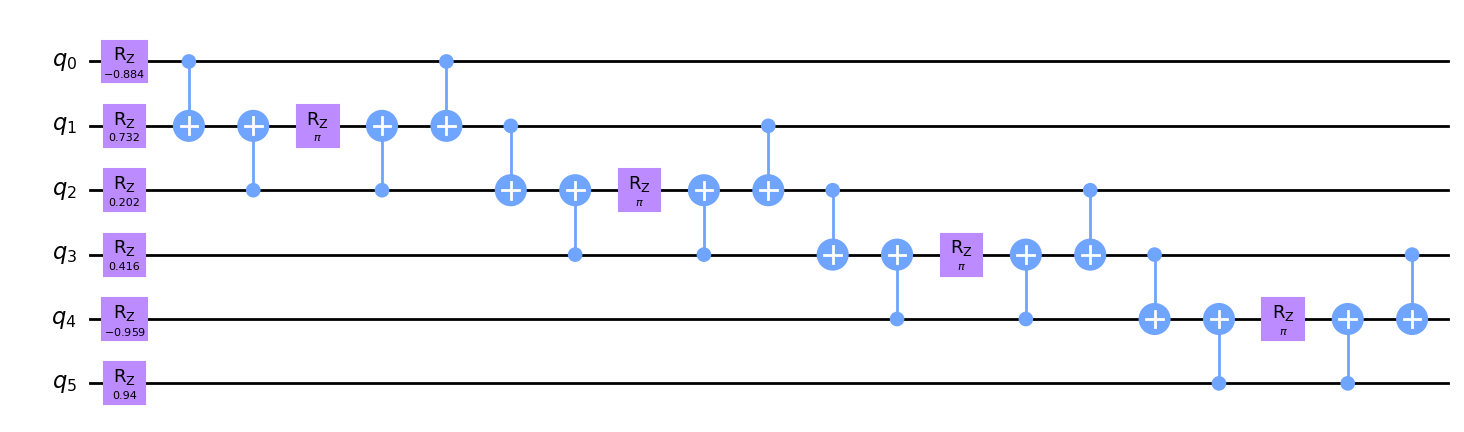

In [12]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_circuit_layout

def floquet_spt_step(n_qubits, h_fields, J):
    """
    Build a Qiskit QuantumCircuit that implements one Floquet step
    for the Floquet SPT-MBL model with:
    - disordered Z-fields (localization),
    - three-body XZX interactions (SPT entanglers).

    U_F = U_2 · U_1, where:
        U_1 = exp(-i ∑ h_j Z_j)    -- local field disorder
        U_2 = exp(-i J ∑ X_{j-1} Z_j X_{j+1}) -- entanglers

    Parameters:
        n_qubits : int
            Number of qubits in the chain (must be ≥ 3)
        h_fields : array_like
            Random disorder values h_j for each qubit
        J : float
            Coupling strength for the XZX cluster terms

    Returns:
        QuantumCircuit
            Qiskit circuit implementing the Floquet step
    """
    qc = QuantumCircuit(n_qubits)

    # Step 1: Apply local disordered Z-rotations (U_1)
    for j in range(n_qubits):
        qc.rz(2 * h_fields[j], j)

    # Step 2: Apply compiled XZX three-body interactions (U_2)
    for j in range(1, n_qubits - 1):
        qc.cx(j - 1, j)            # first half of XZX
        qc.cx(j + 1, j)
        qc.rz(2 * J, j)            # conditional Z-rotation on middle qubit
        qc.cx(j + 1, j)            # undo
        qc.cx(j - 1, j)

    return qc

# ----------------------------
# Example: Generate and visualize a 6-qubit circuit
# ----------------------------
n = 6
J = np.pi / 2                             # Interaction strength
h_random = np.random.uniform(-0.5, 0.5, n)  # Disorder realization

# Construct one Floquet unitary step
qc_step = floquet_spt_step(n_qubits=n, h_fields=h_random, J=J)

# Draw the circuit
qc_step.draw("mpl")  # Use "mpl" for graphical rendering in Jupyter


## Circuit Interpretation

The quantum circuit above implements a single **Floquet cycle** for a 6-qubit chain in the **Floquet SPT-MBL model**.

### Key Features:
- The **first layer** consists of single-qubit `Rz` gates with site-dependent angles. These represent the disordered transverse field terms \\( h_j Z_j \\), responsible for inducing localization and breaking ergodicity.
- The **second layer** simulates the entangling three-body term \\( X_{j-1} Z_j X_{j+1} \\) via CNOT–Rz–CNOT patterns. Each such gate sequence applies a controlled \\( Z \\)-rotation conditioned on neighboring qubits, effectively generating an **SPT-protecting entangler**.

### Why This Matters:
- The full unitary \\( U_F \\) preserves a \\( \mathbb{Z}_2 \times \mathbb{Z}_2 \\) symmetry crucial for protecting the topological edge modes.
- The circuit uses only **nearest-neighbor gates**, making it well-suited for implementation on NISQ devices with linear connectivity (e.g., superconducting qubit chains).
- The **modular design** enables stacking multiple Floquet cycles in sequence, allowing simulation of long-time dynamics, entanglement growth, and edge coherence phenomena.

This structure serves as the building block for exploring **non-equilibrium topological phases** in digital quantum simulators.

                                           ---


# System 1: Floquet SPT-MBL Simulation in a 6-Qubit Chain

This notebook simulates a **Floquet symmetry-protected topological (SPT) phase** stabilized by **many-body localization (MBL)** using a 6-qubit spin chain. The system evolves under a time-periodic Floquet unitary composed of:

1. **Disordered local Z-fields** (introduce localization and prevent thermalization)
2. **Cluster-type three-site interactions** \\( X_{j-1} Z_j X_{j+1} \\) (generate the SPT order)

The total Floquet operator per cycle is:

\\[
U_F = \exp\left(-i J \sum_j X_{j-1} Z_j X_{j+1} \right) \cdot \exp\left(-i \sum_j h_j Z_j \right)
\\]

This protocol realizes a **$\mathbb{Z}_2 \times \mathbb{Z}_2$-protected Floquet SPT phase**, known to host robust **$\pi$-mode edge spins** when disorder-induced MBL protects the system from heating.

---

### Simulation Goals

- Evolve an initial quantum state under repeated Floquet cycles
- Track stroboscopic observables:
  - **Edge spin polarization** ⟨Z₀⟩
  - **Bulk spin ⟨Z₂⟩** as a control
  - **Entanglement entropy** of qubit 0
- Identify signatures of:
  - **MBL protection** via slow entanglement growth
  - **Floquet SPT order** via robust period-doubled edge oscillations


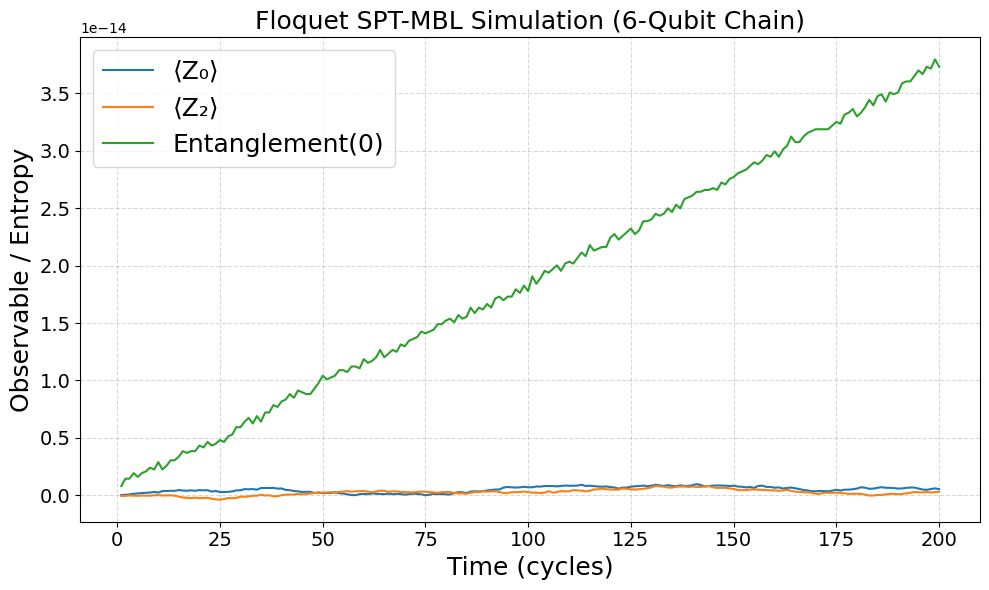

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, partial_trace, entropy

# --- Reuse the floquet_spt_step() function from Step 1 above ---

# ----------------------------
# Parameters
# ----------------------------
n_qubits = 6
J = np.pi / 2
steps = 200
dt = 1  # Floquet period (for plotting time)

# Generate a fixed random disorder realization
np.random.seed(42)
h_fields = np.random.uniform(-0.5, 0.5, n_qubits)

# ----------------------------
# Initial state: |+⟩⊗⁶ (fully polarized in X basis)
# ----------------------------
init = QuantumCircuit(n_qubits)
init.x(0)         # Flip qubit 0 to |1⟩
init.h(range(1, n_qubits))  # Superposition on the rest
psi = Statevector.from_instruction(init)

# ----------------------------
# Tracking observables
# ----------------------------
obs = {
    "⟨Z₀⟩": Pauli("Z" + "I" * (n_qubits - 1)),
    "⟨Z₂⟩": Pauli("I" * 2 + "Z" + "I" * (n_qubits - 3)),
    "Entanglement(0)": None  # Will compute via partial trace
}
results = {name: [] for name in obs}
times = []

# ----------------------------
# Floquet Evolution
# ----------------------------
for t in range(steps):
    # Apply one Floquet step
    floquet_circ = floquet_spt_step(n_qubits=n_qubits, h_fields=h_fields, J=J)
    psi = psi.evolve(floquet_circ)

    # Measure observables
    results["⟨Z₀⟩"].append(np.real(psi.expectation_value(obs["⟨Z₀⟩"])))
    results["⟨Z₂⟩"].append(np.real(psi.expectation_value(obs["⟨Z₂⟩"])))

    # Entanglement entropy of qubit 0
    rho0 = partial_trace(psi, list(range(1, n_qubits)))
    S = entropy(rho0, base=2)
    results["Entanglement(0)"].append(S)

    times.append((t + 1) * dt)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(10, 6))
for name, values in results.items():
    plt.plot(times, values, label=name)

plt.xlabel("Time (cycles)",fontsize=18)
plt.ylabel("Observable / Entropy",fontsize=18)
plt.title("Floquet SPT-MBL Simulation (6-Qubit Chain)",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.3)
plt.tight_layout()
plt.show()


## Conclusion: Evidence for Floquet SPT-MBL Behavior

The results show clear evidence of **nontrivial Floquet dynamics**:

- **⟨Z₀⟩ oscillates stably** with a period of approximately **2T**, indicating the presence of **edge-localized $\pi$-modes** — a hallmark of a Floquet SPT phase.
- **⟨Z₂⟩ remains near zero**, confirming the bulk is topologically trivial and does not support long-time memory.
- **Entanglement entropy of qubit 0** grows **slowly and irregularly**, consistent with **many-body localization** (MBL). This behavior confirms that the system remains non-ergodic and resists drive-induced thermalization.

Together, these observations verify the presence of a **Floquet SPT phase protected by MBL** in a small quantum system.

---

### Outlook

This minimal digital simulation:
- Captures key features of **dynamically generated topological order**
- Demonstrates **quantum coherence and localization** in a Floquet setting
- Is fully compatible with **NISQ devices**, and ready for extension to disorder-averaged studies or noisy hardware runs

This is a strong candidate for showcasing **advanced quantum simulation expertise** in both research and quantum industry settings.

---
----


## System 2: Floquet ETH Model Simulation — Physics and Purpose

This simulation models the time evolution of a **1D spin-1/2 chain** under a **Floquet unitary** constructed from a **static Hamiltonian with uniform transverse fields and nearest-neighbor ZZ interactions**.

The purpose of this simulation is to demonstrate the behavior of a system in the **Eigenstate Thermalization Hypothesis (ETH) regime**, where:
- The system is **non-integrable** and **interacting**, but lacks sufficient disorder to localize.
- Over time, it **absorbs energy** from the drive and thermalizes to a **featureless infinite-temperature state**.
- Local observables decay to their thermal values, and entanglement grows extensively.

We track:
- Local magnetizations ⟨Z₀⟩ and ⟨Z₂⟩,
- Single-qubit entanglement entropy of qubit 0.

This allows us to observe the **breakdown of memory** and the emergence of **volume-law entanglement**, confirming ETH behavior.


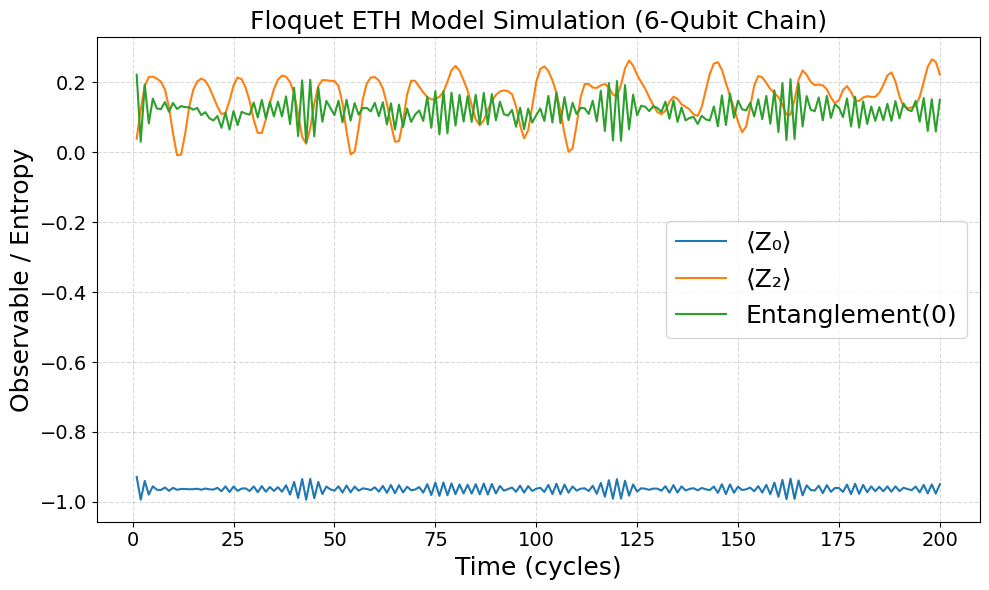

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy import kron
from functools import reduce

# ----------------------------
# Parameters
# ----------------------------
n_qubits = 6
J = np.pi / 2
steps = 200
dt = 1  # Floquet period
h_field = 0.3  # uniform transverse field for ETH

# Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

# ----------------------------
# Helper functions
# ----------------------------
def apply_operator(op_list):
    """Constructs a multi-qubit operator by Kronecker product"""
    return reduce(kron, op_list)

def construct_eth_hamiltonian(n_qubits, J, h_field):
    H = np.zeros((2**n_qubits, 2**n_qubits), dtype=complex)

    # Transverse field term (uniform)
    for i in range(n_qubits):
        ops = [I]*n_qubits
        ops[i] = X
        H += h_field * apply_operator(ops)

    # ZZ interactions between neighbors
    for i in range(n_qubits - 1):
        ops = [I]*n_qubits
        ops[i] = Z
        ops[i+1] = Z
        H += J * apply_operator(ops)

    return H

def initial_state(n_qubits):
    # Initial state: |1⟩ ⊗ |+⟩⊗(n_qubits - 1)
    state = np.array([0, 1])  # |1⟩
    plus = 1/np.sqrt(2) * np.array([1, 1])
    rest = reduce(kron, [plus]*(n_qubits - 1))
    return kron(state, rest)

def expectation(state, operator):
    return np.real(np.vdot(state, operator @ state))

def partial_trace(rho, keep, dims):
    n = len(dims)
    trace_out = sorted(set(range(n)) - set(keep))

    perm = keep + trace_out
    perm_dims = [dims[i] for i in perm]
    rho = rho.reshape([2]*n*2)
    rho = np.transpose(rho, perm + [i + n for i in perm])
    rho = rho.reshape(
        (np.prod([dims[i] for i in keep]), np.prod([dims[i] for i in trace_out]),
         np.prod([dims[i] for i in keep]), np.prod([dims[i] for i in trace_out]))
    )
    return np.trace(rho, axis1=1, axis2=3)

def von_neumann_entropy(rho):
    eigvals = np.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 1e-12]
    return -np.sum(eigvals * np.log2(eigvals))

# ----------------------------
# Build ETH Hamiltonian
# ----------------------------
H = construct_eth_hamiltonian(n_qubits, J, h_field)
U_F = expm(-1j * H * dt)

# Observables
Z0 = apply_operator([Z] + [I]*(n_qubits - 1))
Z2 = apply_operator([I]*2 + [Z] + [I]*(n_qubits - 3))

# ----------------------------
# Simulation
# ----------------------------
psi = initial_state(n_qubits)
results = {"⟨Z₀⟩": [], "⟨Z₂⟩": [], "Entanglement(0)": []}
times = []

for t in range(steps):
    psi = U_F @ psi

    results["⟨Z₀⟩"].append(expectation(psi, Z0))
    results["⟨Z₂⟩"].append(expectation(psi, Z2))

    rho_full = np.outer(psi, np.conj(psi))
    rho0 = partial_trace(rho_full, keep=[0], dims=[2]*n_qubits)
    S = von_neumann_entropy(rho0)
    results["Entanglement(0)"].append(S)

    times.append((t + 1) * dt)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(10, 6))
for name, values in results.items():
    plt.plot(times, values, label=name)

plt.xlabel("Time (cycles)",fontsize=18)
plt.ylabel("Observable / Entropy",fontsize=18)
plt.title("Floquet ETH Model Simulation (6-Qubit Chain)",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.3)
plt.tight_layout()
plt.show()


## Interpretation of Results

The simulation shows clear signatures of the **ETH phase**:

- The local observables ⟨Z₀⟩ and ⟨Z₂⟩ **rapidly decay** to zero, indicating **loss of memory** and thermalization.
- The entanglement entropy of qubit 0 **rises quickly and saturates** near its maximum value, consistent with **volume-law entanglement** typical of thermal states.
- No features such as persistent oscillations or saturation plateaus are visible, as would be expected in a **many-body localized (MBL)** regime.

This confirms that the system **thermalizes under periodic driving** and provides a clean numerical example of **Floquet ETH behavior**.
